# Anova analysis
Takes df with meta after all preprocessing steps

In [411]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests

In [412]:
%run 82_label_modifying.ipynb

/home/arleg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Load data

In [413]:
name = 'normalized_with_meta_log_transformed_substituted_NA_cleaned_control_cleaned_isotopes_cleaned_contaminants_xs_annotated_rats_neg.csv'
df = pd.read_csv(name, index_col=0)

/home/arleg/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [414]:
# Unrelevant columns and rowws
non_peaks = ['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 'npeaks', 'samples', 'isotopes', 'adduct', 'pcgroup']
unrelevant_features = ['id', 'mass']

In [415]:
# Get rid of unrelevant peaks and rows
df = df.drop(non_peaks, axis=1)
df = df.drop(unrelevant_features, axis=0)

In [416]:
# Transpose df
df = df.T

# Kill NA
df.dropna(axis=0, subset=['age'], inplace=True)
# Convert intensities to float
df = df.apply(lambda x: pd.to_numeric(x, errors='ignore'))

## Anova of all rats

In [417]:
# Look at the number of samples per each age-tissue group
xx = df[[19, 'tissue', 'age']]
xx.pivot_table(index=['age'], columns='tissue', aggfunc='count')

19                              
tissue brain_cb brain_pfc liver muscle plasma
age                                          
old_1         6         5     2      6      6
old_2         6         6     5      5      6
young         6         6     3      7      6

In [561]:
def anova(df, variables, interaction='double'):
    """
    Conduct anova for each column on columns in variables - each column in df except those which are in variables will
    be analysed vs those in variables
    Assumes that there are 2 non numeric columns which are the last at df. Should be fixed (probably with re)
    :param df: df - dataframe, which contains all aforementioned columns
    :param variables: list - list with column names which will be used in anova
    :param interaction: str - one of 'no', 'double' and 'multiple' denoting type of interaction
    :return: df - dataframe with shape len(variables) + their interactions X len(df.columns) - len(varibles) with
    p-value for each analysis
    """
    # Create df for p-values of all interactions in anova
    pvs = pd.DataFrame()

    # Conduct anova for each peak by age and tissue with interaction and add information to dataframe
    for peak in df.columns[:-2]:
        formula = construct_formula(peak, variables, interaction=interaction)
        model = smf.ols(formula, df).fit()
        
        # Take column with p-value for each of group
        analysis = sm.stats.anova_lm(model)['PR(>F)'].drop('Residual')
        pvs[peak] = analysis
    return pvs

In [440]:
def construct_formula(y, xs, interaction='double'):
    """
    Create formula string for patsy in statsmodels
    :param y: str - name of dependent column
    :param xs: iterable - list with names of dependent columns
    :param interaction: str - one of 'no', 'double' and 'multiple' - whether formula will contain interaction terms
    :return: str - formula for statsmodels
    """
    # Convert numeric terms to appropriate form
    y = numeric_term(y)
    xs = list(map(numeric_term, xs))
    
    # Construct formula
    formula = interactions(y, xs, interaction)
    return formula


def interactions(y, xs, interaction):
    """
    Construct the formula depending on interaction type
    :param y: str - name of dependent column
    :param xs: iterable - list with names of dependent columns
    :param interaction: str - one of 'no', 'double' and 'multiple' - whether formula will contain interaction terms
    :return: str - formula for statsmodels
    """
    # Define formaulae for different interaction types and return appropriate
    interaction_types = {'multiple': f'{y} ~ ({" + ".join(xs)}) ** {len(xs)}',
                         'double': f'{y} ~ ({" + ".join(xs)}) ** 2',
                         'no': f'{y} ~ {" + ".join(xs)}'}
    return interaction_types[interaction]


def numeric_term(x):
    """
    Convert numeric term in formula to appropriate form for patsy
    If term is non-numeric it will be returned
    :param x: str - name of column
    :return: str - term in appropriate form
    """
    # For int numeric terms
    if isinstance(x, int):
        return f'Q({x})'
    # For str numeric terms
    elif x.isdigit():
        return f'Q("{x}")'
    return x

In [441]:
def conduct_anova_for_all_peaks_vs_some_variables(df, variables, interaction='double'):
    """
    Conduct anova for each peak in df vs columns listed in variables
    :param df: dataframe - df with samples - rows and peaks and features - columns (normal form)
    :param variables: list - list with column names which will be used in anova
    :param interaction: str - one of 'no', 'double' and 'multiple' denoting type of interaction
    :return: masked dataframe with shape len(variables) + their interactions X len(df.columns) - len(varibles) with
    adjusted p-value for each analysis
    """
    # Get p-values for each analysis
    pvs = anova(df, variables, interaction)
    # Flatten p-value df into 1-dimensional array
    p_values = pvs.values.ravel()

    # Adjust p-values with Benjamini/Hochberg procedure
    p_values_corrected = multipletests(p_values, method='fdr_tsbh')
    bool_p = p_values_corrected[0].reshape(pvs.shape)
    cor_p = p_values_corrected[1].reshape(pvs.shape)
    # Create df with adjusted p-values and mask that which are higher than 0.05
    p_values_corrected = pd.DataFrame(cor_p, columns=pvs.columns, index=pvs.index)
    p_value_appropriate = p_values_corrected[pd.DataFrame(bool_p, columns=pvs.columns, index=pvs.index)]
    return p_value_appropriate

## p-value correction

In [432]:
# Get p-values for each analysis
pvs = anova(df, ['tissue', 'age'], interaction='double')

In [433]:
# Flatten p-value df into 1-dimensional array
# They are stacked in this manner: 1st row...2nd row...3rd row - shape is (1, everything)
p_values = pvs.values.ravel()

In [434]:
# First element is an array with indication whether the p-value is appropriate according to Benjamini/Hochberg
p_values_corrected = multipletests(p_values, method='fdr_tsbh')

In [435]:
# Obtain a df where all insignificant p-values are masked with NA
bool_p = p_values_corrected[0].reshape((3, 4233))
cor_p = p_values_corrected[1].reshape((3, 4233))
p_values_corrected = pd.DataFrame(cor_p, columns=pvs.columns, index=pvs.index)
p_value_appropriate = p_values_corrected[pd.DataFrame(bool_p, columns=pvs.columns, index=pvs.index)]

In [436]:
p_value_appropriate

,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
tissue,1.152835e-28,4.337263e-25,4.896027e-22,6.972622e-30,1.920721e-22,1.032768e-23,4.436472e-26,1.564014e-20,1.607652e-26,6.108033e-21,...,4.339157e-26,2.189962e-24,5.610653e-24,1.153352e-21,9.603303e-21,1.227601e-25,2.068044e-22,1.137953e-20,1.048761e-16,3.812030e-22
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tissue:age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [437]:
# Number of significant peaks per each category
(~p_value_appropriate.isna()).sum(axis=1)

tissue        4233
age              6
tissue:age       2
dtype: int64

In [438]:
# Significant peaks in tissue-age interaction
p_value_appropriate.loc['tissue:age'].dropna()

6397    0.032051
3320    0.044094
Name: tissue:age, dtype: float64

In [334]:
# Significant peaks in age
p_value_appropriate.loc['age'].dropna()

9280    0.022337
5081    0.035734
5083    0.046773
5740    0.048114
8051    0.040853
9429    0.027782
Name: age, dtype: float64

In [327]:
# Insignificant peaks in tissue
p_value_appropriate.loc['tissue', p_value_appropriate.loc['tissue'].isna()]#dropna()

Series([], Name: tissue, dtype: float64)

## Anova on old rats

In [420]:
# Get old rats which consist from rats with additional vitamin D and those without it
olds_ind = df['age'] != 'young'
olds = df[olds_ind]

In [348]:
# Get adjusted p-values for significant ones
variables = ['tissue', 'age']
olds_p_value = conduct_anova_for_all_peaks_vs_some_variables(olds, variables, interaction='double')

In [355]:
# Number of significant peaks per each category
(~olds_p_value.isna()).sum(axis=1)

tissue        4233
age              3
tissue:age       8
dtype: int64

In [360]:
# Significant peaks in tissue-age interaction
olds_p_value.loc['tissue:age'].dropna()

6397    0.007791
3320    0.043994
4706    0.044562
5687    0.045455
6371    0.022324
6396    0.013412
6424    0.020898
7264    0.035128
Name: tissue:age, dtype: float64

In [387]:
# Significant peaks in age
olds_p_value.loc['age'].dropna()

6395    0.013865
8052    0.048644
8065    0.048779
Name: age, dtype: float64

In [358]:
# Insignificant peaks in tissue
olds_p_value.loc['tissue', olds_p_value.loc['tissue'].isna()]#dropna()

Series([], Name: tissue, dtype: float64)

## Anova by age for tissues separately

## All rats with separate tissues

In [383]:
anova_per_tissue = {}

for tissue in df.tissue.unique():
    ss = df[df['tissue'] == tissue]
    anova_per_tissue[tissue] = conduct_anova_for_all_peaks_vs_some_variables(ss, ['age'])

/home/arleg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/arleg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/arleg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/arleg/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/home/arleg/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [391]:
# Display significant p-values
for k, v in anova_per_tissue.items():
    print(k)
    display(v)
    display(v.loc['age'].dropna())

brain_cb


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

brain_pfc


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

muscle


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

plasma


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

liver


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

## Only old with separate tissues

In [427]:
anova_olds_per_tissue = {}

for tissue in df.tissue.unique():
    ss = olds[olds['tissue'] == tissue]
    anova_olds_per_tissue[tissue] = conduct_anova_for_all_peaks_vs_some_variables(ss, ['age'])

/home/arleg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/arleg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/arleg/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
/home/arleg/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:320: RuntimeWarning: invalid value encountered in less_equal
  reject = pvals_sorted <= ecdffactor*alpha
/home/arleg/anaconda3/lib/python3.6/site-packages/statsmodels/stats/multitest.py:251: RuntimeWarning: invalid value encountered in greater
  pvals_corrected[pvals_corrected>1] = 1


In [428]:
# Display significant p-values
for k, v in anova_olds_per_tissue.items():
    print(k)
    display(v)
    display(v.loc['age'].dropna())

brain_cb


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

brain_pfc


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

muscle


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


6346    0.019059
Name: age, dtype: float64

plasma


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

liver


,19,1855,1920,1928,1962,1970,1987,2060,2231,2272,...,9623,9624,9625,9626,9627,9628,9629,9630,9631,9633
age,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Series([], Name: age, dtype: float64)

## Results
In anova with all age groups, tissues and their interactions difference in intensities in all peaks are significant for tissue.  
Difference in **9280, 5081, 5083, 5740, 8051, 9429** peak intensities are significant for age and **6397, 3320** for age-tissue interaction

Results for only old rats are almost the same - **6397, 3320, 4706, 5687, 6371, 6396, 6424, 7264** peak intensities are significant for age-tissue interaction, and **6395, 8052, 8065** are significant for age, meanwhile all peak intensities are significant for tissue.

There is no peaks with significant difference in intensity between age groups if we conduct anova for each tissue separately and only 1 peak (**6346**) in *muscle* was considered significant when anova is conducted only on 2 old groups.

|type|significance type|significant peaks|
|--|--|--|
|everything with interactions|tissue|all|
||age|9280, 5081, 5083, 5740, 8051, 9429|
||tissue:age|6397, 3320|
|only old rats with interactions|tissue|all|
||age|6395, 8052, 8065|
||tissue:age|6397, 3320, 4706, 5687, 6371, 6396, 6424, 7264|
|everything with separate tissue|age|no|
|only old rats with separate tissue|age|6346 in muscle|

## Permutation test

In [ ]:
def r():
    pass

In [481]:
results_permutation = pd.DataFrame(columns=['tissue', 'age', 'tissue:age'])

In [488]:
results_permutation.loc[0] = (tt.loc['tissue'].dropna(), tt.loc['age'].dropna(), tt.loc['tissue:age'].dropna())

In [505]:
# Get peaks with p-value for 1 interaction in permutation
results_permutation.loc[0, 'age']

423     0.031631
2504    0.036009
2739    0.029662
2858    0.044841
2859    0.032130
596     0.023528
3244    0.004865
3818    0.020588
3822    0.022619
3854    0.040298
4205    0.016227
4502    0.024895
4890    0.046606
4928    0.041318
5434    0.019275
5903    0.043804
5980    0.008252
6538    0.024877
6541    0.032370
6866    0.021198
6994    0.025461
6998    0.021087
853     0.007311
7115    0.033379
7168    0.028155
7780    0.032524
7881    0.021570
983     0.010819
8030    0.033767
8039    0.024585
          ...   
9351    0.031437
9353    0.018629
9355    0.016476
9357    0.026022
9366    0.030321
9367    0.033689
9373    0.048095
9375    0.017388
9376    0.041321
9388    0.000903
9391    0.016166
9403    0.021140
9404    0.033003
9441    0.021583
9458    0.048357
9459    0.005638
9462    0.003437
9463    0.000626
9466    0.047000
9469    0.019379
9470    0.016364
9479    0.010637
9480    0.025446
9542    0.014804
9543    0.034118
9544    0.036232
9545    0.018012
9551    0.0178

In [482]:
tt = conduct_anova_for_all_peaks_vs_some_variables(df, ['tissue', 'age'], interaction='double')

In [487]:
tt.loc['tissue'].dropna()

19      6.828173e-30
1855    6.189234e-27
1920    8.555087e-23
1928    2.653187e-30
1962    2.546763e-22
1970    4.206670e-25
1987    4.417430e-27
2060    2.641804e-22
2231    1.309296e-28
2272    3.096498e-22
423     7.240332e-29
2281    3.785592e-23
2295    3.184463e-23
2324    4.322543e-27
2372    6.415570e-22
2375    4.047432e-21
2504    2.822306e-22
2537    1.633765e-20
2609    1.819823e-35
2650    3.276599e-25
2665    3.093452e-30
2723    9.832072e-20
2739    5.121765e-25
2741    2.236697e-21
486     2.744770e-25
2770    6.815683e-28
2771    1.618044e-27
2825    3.654110e-23
2830    1.115354e-29
2858    1.147432e-24
            ...     
9602    7.822912e-23
9603    2.613825e-25
9604    1.610182e-25
9605    8.323726e-26
9606    2.976897e-17
9607    5.686975e-19
9608    2.279523e-20
9609    3.816506e-26
9610    4.188142e-26
9611    2.278853e-25
9612    1.649399e-26
9613    8.859805e-26
9614    1.227445e-28
9615    7.336399e-31
9617    2.014794e-25
9618    2.050275e-34
9619    4.481

In [517]:
n = 500
variables = ['tissue', 'age']

# Conduct anova n times
for i in range(102, n + 1):
    # Shuffle age labels
    np.random.shuffle(df.age.values)
    # Compute BH corrected p-values
    p_vals = conduct_anova_for_all_peaks_vs_some_variables(df, variables, interaction='double')
    # Store significant peaks in result dataframe
    results_permutation.loc[i] = (p_vals.loc['tissue'].dropna(), p_vals.loc['age'].dropna(), p_vals.loc['tissue:age'].dropna())
    if i % 100 == 0:
        print(f'{i}th launch is done')

200th launch is done
300th launch is done
400th launch is done
500th launch is done


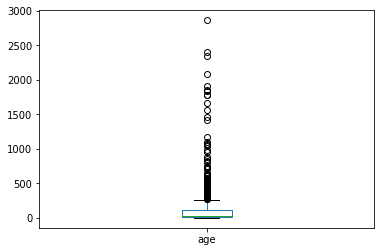

In [548]:
results_permutation.apply(lambda x: x.str.len())['age'].plot(kind='box')

In [549]:
results_permutation.apply(lambda x: x.str.len())['age'].describe()

count     500.000000
mean      160.048000
std       357.649398
min         0.000000
25%        10.000000
50%        28.000000
75%       115.250000
max      2866.000000
Name: age, dtype: float64

In [553]:
(results_permutation.apply(lambda x: x.str.len())['age'] >= 6).sum() / results_permutation.shape[0]

0.882

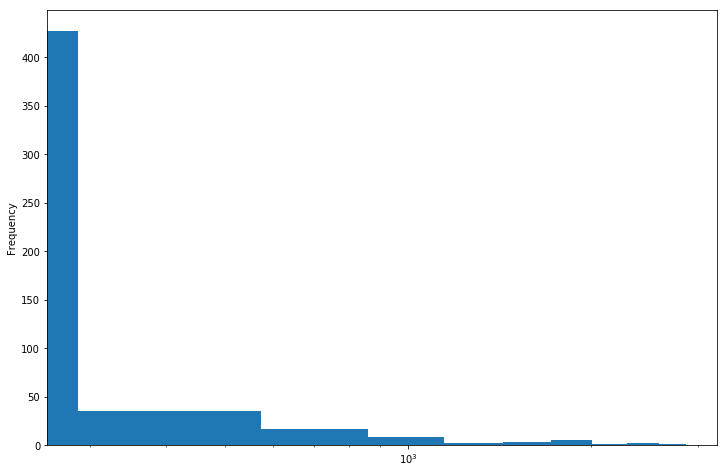

In [546]:
import matplotlib.pyplot as plt
results_permutation.apply(lambda x: x.str.len())['age'].plot(kind='hist', figsize=(12, 8)) #, bins=200
# plt.xscale('log')
# plt.xlim(xmin=0, xmax=960)
# plt.xticks(range(0, 960, 10), rotation=90);
# plt.xlabel()
# results_permutation.apply(lambda x: x.str.len()).describe()

In [520]:
# Significant peaks in tissue-age interaction
olds_p_value.loc['tissue:age'].dropna()

6397    0.007791
3320    0.043994
4706    0.044562
5687    0.045455
6371    0.022324
6396    0.013412
6424    0.020898
7264    0.035128
Name: tissue:age, dtype: float64

In [387]:
# Significant peaks in age
olds_p_value.loc['age'].dropna()

6395    0.013865
8052    0.048644
8065    0.048779
Name: age, dtype: float64

In [443]:
df.age.value_counts()

old_2    28
young    28
old_1    25
Name: age, dtype: int64

In [463]:
df.age.values

array(['old_1', 'young', 'old_2', 'old_2', 'old_1', 'old_1', 'old_2',
       'old_2', 'young', 'old_2', 'old_1', 'young', 'old_2', 'young',
       'old_2', 'old_1', 'old_2', 'old_1', 'old_2', 'young', 'old_2',
       'young', 'young', 'young', 'young', 'young', 'old_1', 'young',
       'old_2', 'old_1', 'young', 'young', 'young', 'old_1', 'old_2',
       'old_2', 'old_2', 'young', 'old_1', 'old_1', 'old_1', 'young',
       'young', 'old_2', 'young', 'old_2', 'old_2', 'old_1', 'old_2',
       'old_1', 'old_2', 'young', 'old_1', 'young', 'young', 'old_1',
       'old_2', 'old_1', 'old_1', 'old_2', 'young', 'old_2', 'young',
       'young', 'old_2', 'old_2', 'old_1', 'old_1', 'old_2', 'old_1',
       'young', 'young', 'young', 'old_2', 'old_2', 'old_1', 'young',
       'old_1', 'old_1', 'old_1', 'old_2'], dtype=object)

In [462]:
perm_labs

array(['old_1', 'young', 'old_2', 'old_2', 'old_1', 'old_1', 'old_2',
       'old_2', 'young', 'old_2', 'old_1', 'young', 'old_2', 'young',
       'old_2', 'old_1', 'old_2', 'old_1', 'old_2', 'young', 'old_2',
       'young', 'young', 'young', 'young', 'young', 'old_1', 'young',
       'old_2', 'old_1', 'young', 'young', 'young', 'old_1', 'old_2',
       'old_2', 'old_2', 'young', 'old_1', 'old_1', 'old_1', 'young',
       'young', 'old_2', 'young', 'old_2', 'old_2', 'old_1', 'old_2',
       'old_1', 'old_2', 'young', 'old_1', 'young', 'young', 'old_1',
       'old_2', 'old_1', 'old_1', 'old_2', 'young', 'old_2', 'young',
       'young', 'old_2', 'old_2', 'old_1', 'old_1', 'old_2', 'old_1',
       'young', 'young', 'young', 'old_2', 'old_2', 'old_1', 'young',
       'old_1', 'old_1', 'old_1', 'old_2'], dtype=object)

In [59]:
# mm = sm.OLS(prp2['age'].values, prp2.drop('age', axis=1).values).fit()

# Works!
# mm = smf.ols('age ~ cc', prp2).fit() # 1
# mm = smf.ols('age ~ cc + Q("19") + cc:Q("19")', prp2).fit() # 2 w interactions
# mm = smf.ols('age ~ cc * Q("19")', prp2).fit()